In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy
from scipy import stats
import torch
import matplotlib.pyplot as plt

import torch
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms

from torch.distributions import Gamma, Normal, Bernoulli, MultivariateNormal, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform

from tqdm.auto import trange

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Uniform
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms


In [2]:
# Download MNIST dataset and create dataloaders. 
def binarize(imgs, integer=False):
    threshold = 127 if integer else 0.5
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

train_dataset = datasets.MNIST(root=".", train=True, download=True,
                         transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='.', train=False, download=True,
                             transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of points in dataset: {0}".format(train_dataset.data.shape[0]))
print("Number of batches per epoch: {0}".format(len(train_loader)))

Number of points in dataset: 60000
Number of batches per epoch: 938


In [22]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super().__init__()
        ## encoder ##
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,encoding_dim)
        ## decoder ##
        self.fc3 = nn.Linear(encoding_dim, 256)
        self.fc4 = nn.Linear(256,784)

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = torch.sigmoid(self.fc4(x))
        
        return out

In [28]:
# initialize the NN
encoding_dim = 3
model = Autoencoder(encoding_dim)

In [29]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# reconstruction loss
criterion = nn.MSELoss()

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = binarize(x.reshape(x.shape[0], -1))
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(x, outputs)
        loss.backward()
        train_loss -= loss.item() * len(x)
        optimizer.step()
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t train loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), -loss.item()))

Train Epoch: 0 [0/60000 (0%)]	 train loss: -0.251035
Train Epoch: 0 [32000/60000 (53%)]	 train loss: -0.075885
Train Epoch: 1 [0/60000 (0%)]	 train loss: -0.073291
Train Epoch: 1 [32000/60000 (53%)]	 train loss: -0.072078
Train Epoch: 2 [0/60000 (0%)]	 train loss: -0.070158
Train Epoch: 2 [32000/60000 (53%)]	 train loss: -0.065074
Train Epoch: 3 [0/60000 (0%)]	 train loss: -0.066598
Train Epoch: 3 [32000/60000 (53%)]	 train loss: -0.063595
Train Epoch: 4 [0/60000 (0%)]	 train loss: -0.065527
Train Epoch: 4 [32000/60000 (53%)]	 train loss: -0.064770
Train Epoch: 5 [0/60000 (0%)]	 train loss: -0.065756
Train Epoch: 5 [32000/60000 (53%)]	 train loss: -0.068880
Train Epoch: 6 [0/60000 (0%)]	 train loss: -0.068173
Train Epoch: 6 [32000/60000 (53%)]	 train loss: -0.059294
Train Epoch: 7 [0/60000 (0%)]	 train loss: -0.066495
Train Epoch: 7 [32000/60000 (53%)]	 train loss: -0.068351
Train Epoch: 8 [0/60000 (0%)]	 train loss: -0.060196
Train Epoch: 8 [32000/60000 (53%)]	 train loss: -0.061564
T

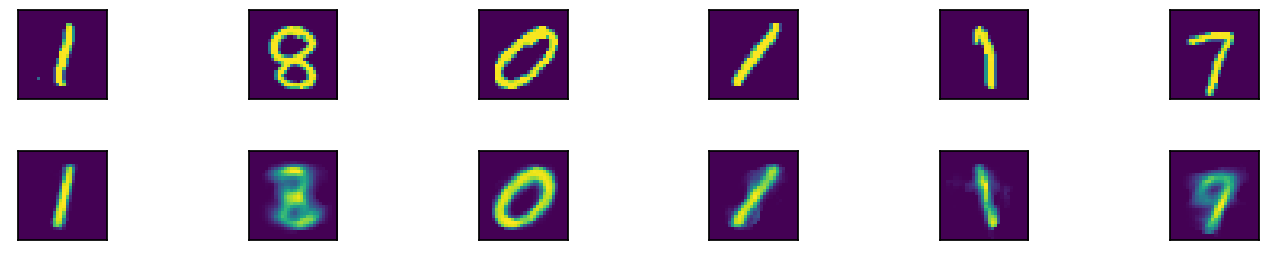

In [87]:
# Visualize some digits in the dataset.
imgs, _ = next(iter(train_loader))
#imgs = binarize(imgs)
fig, ax = plt.subplots(2, 6, figsize=(14, 3))
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    if i < 6:
        ax.imshow(imgs[i].squeeze()) # original images
    else: 
        # reconstructed images
        ax.imshow(model(imgs[i-6].squeeze().reshape(-1)).data.reshape(28,-1))

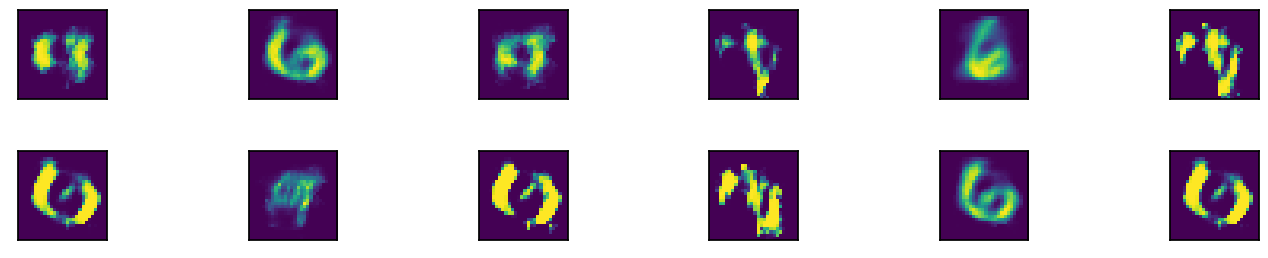

In [78]:
fig, ax = plt.subplots(2, 6, figsize=(14, 3))
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    x = F.relu(model.fc3(torch.randn(3)*3)).detach()
    out = torch.sigmoid(model.fc4(x)).detach().numpy()    
    ax.imshow(out.reshape(28,-1))